# School of Quants. Python. Project №1.

### Buchkov Viacheslav

The project is concentrated on implementation of strategy, based on VPiN and Order Imbalance that allow to detect toxic order flow by Marcos Lopez de Prado et al.

The article for implemetation is https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1695596.

In [1]:
!pip install vectorbt

In [2]:
import numpy as np
import datetime as dt
import pandas as pd
from scipy.stats import norm
import vectorbt as vbt

Data is stored on Google Drive - let's mount it for quick access.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

PATH = 'drive/MyDrive/'
ASSET = 'USDRUB'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


First of all, let's implement configs for Hyperparams and Trading Simulation.

In [4]:
from dataclasses import dataclass

# Strategy hyperparams - set to the most agressive level initially (not tuned, as cross-val is disallowed in the Project 1)
@dataclass
class StrategyHyperparams:
    vpin_threshold: float = .0
    imbalance_threshold: float = .0

@dataclass
class TradingParams:
    initial_capital: float = 20_000_000
    leverage: float = 1.
    commission_fee: float = 0.1

Next, we need to create an OOP framework that will produce trading signals, based on the article's definitions and ideas.

Let's use VPiN as the metric for the flow toxicity (if we see toxic flow, i.e. VPiN is high, something is happening, thus, there is posibility of informed trading, which we can use). For the direction of the potential movement, let's check market-makers' imbalance of quotes.

In [5]:
import pandas as pd


class VpinStrategy:
    """Trading strategy implementation that produces trading signals time series.

    Strategy is based on two parameters - VPiN (The Volume Synchronized Probability of
    INformed Trading) and Quotation Imbalance as per Flow Toxicity and Volatility (http://ssrn.com/abstract=1695596),
    David Easley (Cornell University), Marcos López de Prado (Tudor Investment Corp., RCC at Harvard University) and
    Maureen O'Hara (Cornell University).

    Attributes:
        RESAMPLE_PERIOD (str): Timeframe at which the strategy operates (as per pandas definition).
        WINDOW_LENGTH (str): Timebars window length.
        BUCKET_SIZE (int): Size of the base asset's trading volume that is considered to be "standard".

    """
    RESAMPLE_PERIOD = '1min'
    WINDOW_LENGTH = 50
    BUCKET_SIZE = 1_000_000

    def __init__(
            self,
            vpin_threshold: float,
            imbalance_threshold: float,
            weight_increase: float,
            max_leverage: float,
            trades: pd.DataFrame,
            quotes: pd.DataFrame,
    ):
        """__init__ method.

        Args:
            vpin_threshold (float): Threshold for VPIN-based "Buy"/"Sell" signal, hyperparameter.
            imbalance_threshold (float): Threshold for QuoteImbalance-based "Buy"/"Sell" signal, hyperparameter.
            weight_increase (float): Level by which the position changes (in %), when there is trading
                                     signal, hyperparamemeter.
            max_leverage (float): Maximum level of leverage, allowed in the strategy.
            trades (pd.DataFrame): Dataset of trades data that should include VWAP prices and volumes for each
                                   timestamp.
            quotes (pd.DataFrame): Dataset of orderbook VWAP bid-ask quotes (already calculated)

        """
        self.vpin_threshold = vpin_threshold
        self.imbalance_treshold = imbalance_threshold

        self.weight_increase = weight_increase
        self.max_leverage = max_leverage

        self.trades = trades
        self.quotes = quotes

        # Initialize attributes that hold data in the instance
        self._dataset = None
        self._weights = None

    def get_z_score(self, feature: pd.Series, max_sigmas: float = 3.) -> pd.Series:
        """Calculate z-score for given distribution of values and restrict by max_sigmas value.

        Args:
            feature (pd.Series): Some feature value, assumed to follow chosen distribution.
            max_sigmas (float): Maximum number of sigmas that is considered to be critical for chosen distribution.

        Returns:
            pd.Series.

        """
        # Get rolling mean and std
        mean = feature.rolling(window=self.WINDOW_LENGTH).mean()
        std = feature.rolling(window=self.WINDOW_LENGTH).std()

        # Compute z-scores
        z_scores = (feature - mean) / std
        z_scores[z_scores > max_sigmas] = max_sigmas
        z_scores[z_scores < -max_sigmas] = -max_sigmas

        return z_scores

    def _init_dataset(self) -> None:
        """Initialize the dataset from trades and quotes data (in-place)."""
        # Dispense from the timestamp UTC
        self.trades['time'] = pd.to_datetime(self.trades['time']).dt.tz_localize(None)
        self.quotes['time'] = pd.to_datetime(self.quotes['time']).dt.tz_localize(None)

        # Order trades and quotes
        self.trades.sort_values('time', inplace=True)
        self.quotes.sort_values('time', inplace=True)

        # Reset indices and merge two datasets by nearest timestamp value
        # inside (!) a minute (will trade next minute, so no bias produced)
        quotes_reindex = self.quotes.set_index('time').reindex(self.trades.set_index('time').index,
                                                               method='nearest').reset_index()
        self._dataset = pd.merge(self.trades, quotes_reindex, on='time').set_index('time')

    def _add_quote_volumes(self) -> None:
        """Add bid and ask quotation volumes from share_of_bids data (in-place)."""
        self._dataset['bid_volume'] = self._dataset['volume_traded'] * self._dataset['share_of_bids']
        self._dataset['ask_volume'] = self._dataset['volume_traded'] * (1 - self._dataset['share_of_bids'])

    def _create_buckets(self, df_in: pd.DataFrame) -> pd.DataFrame:
        """Create volume buckets in order to produce discrete quotation data.

        Args:
            df_in (pd.DataFrame): Raw quotes dataset.

        Returns:
            pd.DataFrame.

        """
        # Initialize counter
        count = 0
        buy_volume = 0
        sell_volume = 0
        buckets_series = []
        for index, row in df_in.iterrows():
            new_volume = row['volume']
            z = row['z']

            # Fill the bucket until volume is reached
            if self.BUCKET_SIZE < count + new_volume:
                # Get supposed buy and sell volumes by z-value (assuming that large deviations are caused by toxic flow)
                buy_volume = buy_volume + (self.BUCKET_SIZE - count) * z
                sell_volume = sell_volume + (self.BUCKET_SIZE - count) * (1 - z)

                buckets_series.append({'buy': buy_volume, 'sell': sell_volume, 'time': index})
                count = new_volume - (self.BUCKET_SIZE - count)

                # If bucket is not full, continue filling
                if int(count / self.BUCKET_SIZE) > 0:
                    for i in range(0, int(count / self.BUCKET_SIZE)):
                        buy_volume = self.BUCKET_SIZE * z
                        sell_volume = self.BUCKET_SIZE * (1 - z)
                        buckets_series.append({'buy': buy_volume, 'sell': sell_volume, 'time': index})

                count = count % self.BUCKET_SIZE
                buy_volume = count * z
                sell_volume = count * (1 - z)
            else:
                buy_volume = buy_volume + new_volume * z
                sell_volume = sell_volume + new_volume * (1 - z)
                count = count + new_volume

        return pd.DataFrame(buckets_series).set_index('time')

    def _calculate_vpin(self, resample_period) -> None:
        """Calculate VPiN metric and produce CDF for its values (in-place). Shows order flow toxicity.

        Args:
            resample_period (str): Timeframe at which the strategy operates (as per pandas definition).

        Raises:
            AssertionError: If the dataset provided is not a pandas.DataFrame.

        """
        if self._dataset is None:
            self._init_dataset()

        assert isinstance(self._dataset, pd.DataFrame), f'Expected {pd.DataFrame}, got {type(self._dataset)}'

        # Get resampled data
        trades_resampled = self._dataset['vwap_traded'].diff(1).resample(resample_period).sum().dropna()
        volume_resampled = self._dataset['volume_traded'].resample(resample_period).sum().dropna()

        sigma = trades_resampled.std()
        z = trades_resampled.apply(lambda x: norm.cdf(x / sigma))

        # Create z-values and volumes DataFrame
        vpin_df = pd.DataFrame({'z': z, 'volume': volume_resampled}).dropna()

        # Collect buckets
        buckets = self._create_buckets(vpin_df)

        # Calculate VPiN by rolling window bucket supposed buy-sell deviations
        buckets['VPIN'] = abs(buckets['buy'] - buckets['sell']).rolling(self.WINDOW_LENGTH).mean() / self.BUCKET_SIZE
        buckets['VPIN_CDF'] = buckets['VPIN'].rank(pct=True)

        buckets = buckets.reset_index().drop_duplicates(subset='time', keep='last').set_index('time')
        buckets = buckets.dropna(subset=['VPIN_CDF'])

        self._dataset = self._dataset.join(buckets)

    def _calculate_quote_imbalance(self) -> None:
        """Calculate quotation imbalance metric (difference between bid-ask volumes times bid-ask prices)
        and produce z-scores for its values (in-place). Shows skewness of the market quotes (in-place).

        """
        avg_bid = self._dataset['bid_volume'] * self._dataset['bid'].apply(lambda x: int(x != 0))
        avg_ask = self._dataset['ask_volume'] * self._dataset['ask'].apply(lambda x: int(x != 0))

        imbalance = avg_bid - avg_ask

        self._dataset['imbalance'] = self.get_z_score(imbalance)

    def prepare_target_(self) -> None:
        """Calculate mid-price and returns for the strategy implementation."""
        self._dataset['mid'] = (self._dataset['bid'] + self._dataset['ask']) / 2
        self._dataset['return'] = self._dataset['mid'].pct_change().shift(-1)
        self._dataset['return_sign'] = self._dataset['return'].apply(lambda x: 1 if x > 0 else 0)
        self._dataset.dropna(subset=['return'], inplace=True)

    def _produce_weights(self):
        """Calculate weights for the asset in the strategy, based on features produced (in-place)
        and strategy hyperparameters.

        Note: Strategy does not require training on historical data, so the weights are set by heuristic rules
              (as per paper).

        """
        weights = []

        position = 0
        buy_count = 0
        sell_count = 0

        for index, row in self._dataset.iterrows():
            # Trade only if the flow is toxic enough (informed trading signal), i.e. VPiN is high enough
            if row['VPIN_CDF'] > self.vpin_threshold:
                # If imbalance is skewed up, need to buy
                if row['imbalance'] > self.imbalance_treshold:
                    if position < 0:
                        position = 0

                    # Add gradually weights according to the set hyperparameter
                    position += self.weight_increase
                    buy_count = 10

                # If imbalance is skewed down, need to sell
                if row['imbalance'] < -self.imbalance_treshold:
                    if position > 0:
                        position = 0

                    position -= self.weight_increase
                    sell_count = 10

            # Add gradually weights according to the set hyperparameter
            if position > 0:
                buy_count = buy_count - 1
                if buy_count == 0:
                    position = 0
            elif position < 0:
                sell_count = sell_count - 1
                if sell_count == 0:
                    position = 0

            weights.append({'position': position, 'time': index})

        weights = pd.DataFrame(weights).set_index('time')
        self._weights = self._dataset.join(weights)

    def get_trading_strategy(self) -> pd.DataFrame:
        """Produce weights for the asset, according to the VpinStrategy trading rules.

        Returns:
            pd.DataFrame

        """
        self._init_dataset()
        self._add_quote_volumes()

        self._calculate_vpin(resample_period=self.RESAMPLE_PERIOD)
        self._calculate_quote_imbalance()

        self.prepare_target_()
        self._produce_weights()

        return self._weights

Dataset used will be composed from two core data types - trades (with bid-ask details at the moment of the trade) and quotes (bid-ask VWAPs).

First of all, the trades data from MOEX screen for USDRUB_TOM is used. The data used is from 2017 to 2019 (resampled for 1 min already at the database level), as larger amount of data would be very hard to process.

In [6]:
trades = pd.read_csv(f'{PATH}{ASSET}.csv', parse_dates=['time'])
trades.rename(columns={
    'Total_VOLUME_SUM': 'volume_traded',
    'Total_VWAP_TRADED': 'vwap_traded',
    'Total_SHARE_OF_BIDS': 'share_of_bids'
}, inplace=True)

Secondly, the quotes data is the resampled $500k VWAP bid-asks from USDRUB_TOM MOEX screen (for simplicity assuming that we do not execute _TOD deals).

(!!!) Please, note that the data is already a VWAP (initially gathered as such), so no additional calculation of VWAP prices is present.

In [7]:
quotes = pd.read_csv(f'{PATH}quotes_{ASSET}_resample_1min.csv', parse_dates=['timestamp'])
quotes.rename(columns={
    'timestamp': 'time',
    'Bid': 'bid',
    'Ask': 'ask'
}, inplace=True)

Let's initialize strategy and induce pipline to get trading strategy details (signals and execution prices).

In [8]:
# Initialize strategy factory
vpin_strategy = VpinStrategy(
    vpin_threshold=StrategyHyperparams.vpin_threshold,
    imbalance_threshold=StrategyHyperparams.imbalance_threshold,
    weight_increase=TradingParams.leverage, # Increase position to the maximum level possible
    max_leverage=TradingParams.leverage,
    trades=trades,
    quotes=quotes
)

# Get trading signals for testing
trading_strategy = vpin_strategy.get_trading_strategy()

Let's double-check that everything is correct by looking at features distribution.

<Axes: >

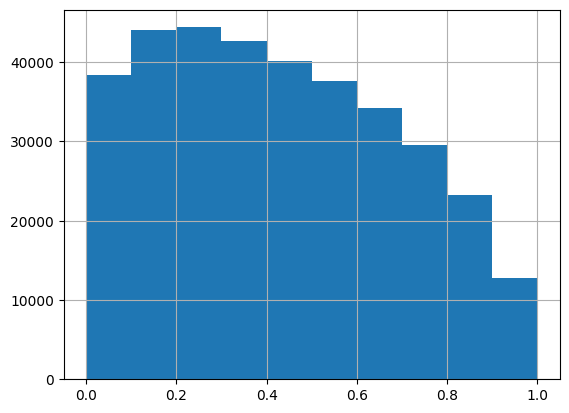

In [9]:
trading_strategy['VPIN_CDF'].hist()

<Axes: >

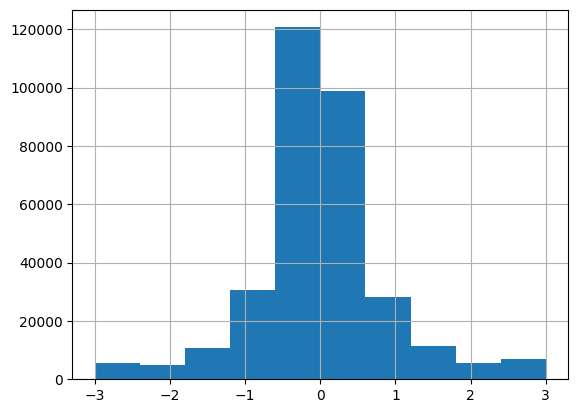

In [10]:
trading_strategy['imbalance'].hist()

Let's transform weights into numpy for VectorBT implementation and impose restrictions on the "No leverage" condition.

In [11]:
def get_weights(strategy_data: pd.DataFrame) -> np.array:
    """Get asset weights for strategy backtesting.

    Args:
        strategy_data (pd.DataFrame): Dataset with trading signals.

    Returns:
        numpy.ndarray.

    """
    return np.array(strategy_data.iloc[:]['position'], dtype=np.float64)

def restrict_leverage(weights: np.array, trading_config: dataclass) -> np.array:
    """Impose restrictions on asset weights by the maximum leverage.

    Args:
        weights (numpy.ndarray): Asset weights for strategy backtesting.

    Returns:
        numpy.ndarray.

    """
    weights = np.where(weights > trading_config.leverage, trading_config.leverage, weights)
    weights = np.where(weights < -trading_config.leverage, -trading_config.leverage, weights)
    return weights

In [12]:
weights = get_weights(trading_strategy)
weights = restrict_leverage(weights, trading_config=TradingParams)
np.unique(weights[weights != .0])

array([-1.,  1.])

As it's assumed that VWAP mid is a good enough estimate for execution (and all other transaction costs are % of volume traded), let's use this simplified variant.

However, a more correct approach would be to use bid-ask prices for the correct volume, so getting ask for positive positions (changes in position) and bid for negative ones as by the code below:


```
trading_strategy['execution_price'] = trading_strategy.shift(-1).apply(lambda row: row['ask'] if row['position'] > 0 else row['bid'], axis=1)
trading_strategy[['bid', 'ask', 'execution_price']].head()
```



Let's create portfolio, based on weights introduced.

In [13]:
pf = vbt.Portfolio.from_orders(
    freq='1min',
    close=np.array(trading_strategy.iloc[:]['mid'], dtype=np.float64),
    price=np.array(trading_strategy.iloc[:]['mid'].shift(1), dtype=np.float64), # .shift(1) - i.e., we get predict at minute(t) and trade at minute(t + 1)
    size=weights,
    size_type='targetpercent',
    direction='both',
    init_cash=TradingParams.initial_capital
)

The metrics, listed in the assignment, are presented below.

In [14]:
final_metrics = {
    'Beta': pf.beta(),
    'Sharpe Ratio': pf.sharpe_ratio(),
    'Calmar Ratio': pf.calmar_ratio(),
    'Total Return': pf.total_return(),
    'Max Drawdown': pf.max_drawdown(),
    'Accumulated Return / Maximimum Drawdown': pf.total_return() / abs(pf.max_drawdown()),
    'VaR': pf.value_at_risk(),
    'ES': pf.cond_value_at_risk()
}

In [15]:
for metric_name, metric_value in final_metrics.items():
    print(f'{metric_name} = {round(metric_value, 4)}')

Beta = -0.0241
Sharpe Ratio = 2.7963
Calmar Ratio = 6.1956
Total Return = 0.4473
Max Drawdown = -0.0783
Accumulated Return / Maximimum Drawdown = 5.7097
VaR = -0.0003
ES = -0.0005


Let's check via assert that "3. Limits on Backtest" are satisfied.

In [16]:
assert final_metrics['Total Return'] > 0 and abs(final_metrics['Beta']) < 0.05 and final_metrics['Max Drawdown'] < 0.3, 'Backtest conditions violated!'

Also, overall metrics are presented as given per VectorBT framework.

In [17]:
pd.options.display.float_format = '{:.2f}'.format
pf.stats(settings=dict(required_return=0.0, risk_free=0.0)).T

Start                                                 0
End                                              491113
Period                                341 days 01:14:00
Start Value                                 20000000.00
End Value                                   28945660.53
Total Return [%]                                  44.73
Benchmark Return [%]                               6.11
Max Gross Exposure [%]                           101.00
Total Fees Paid                                    0.00
Max Drawdown [%]                                   7.83
Max Drawdown Duration                 112 days 14:35:00
Total Trades                                     164187
Total Closed Trades                              164187
Total Open Trades                                     0
Open Trade PnL                                     0.00
Win Rate [%]                                      42.62
Best Trade [%]                                     1.43
Worst Trade [%]                                 

Thanks a lot for checking my work!